In [1]:
import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import transport

In [2]:
lon_min=-58
lat_min=50
lon_max=-55
lat_max=52

In [3]:
data_dir='/ocean/handres/glorys12/'
mask = xr.open_dataset(os.path.join(data_dir,'statics_subset_mask_bathy.nc'))
mask = mask.sel(latitude=slice(lat_min, lat_max),
                longitude=slice(lon_min, lon_max))
coords = xr.open_dataset(os.path.join(data_dir,'statics_subset_coordinates.nc'))
coords = coords.sel(latitude=slice(lat_min, lat_max),
                    longitude=slice(lon_min, lon_max))

In [4]:
transects = pd.read_csv('../../data/sections_info.txt', delim_whitespace=True,
                       names=['Shortname', 'Longname', 'lon1', 'lat1', 'lon2', 'lat2', 'Dir-E', 'Dir-N'],
                       header=0)

In [5]:
belle = transects[transects.Shortname=='SBI']

In [6]:
year='[1,2][0-9][0-9][0-9]'
month='[0,1][0-9]'
f = glob.glob(os.path.join(data_dir,f'*_{year}_daily{month}.nc'))
d = xr.open_mfdataset(f)
dsel = d.sel(time=slice('2002-11-01', '2003-06-01'),
             latitude=slice(lat_min, lat_max),
             longitude=slice(lon_min, lon_max))

In [7]:
num_points=100
lons = np.linspace(belle.lon1.values[0],
                   belle.lon2.values[0],
                   num=num_points)
lats = np.linspace(belle.lat1.values[0],
                   belle.lat2.values[0],
                   num=num_points)
dir_east_perp = belle['Dir-E'].values[0]
dir_north_perp = belle['Dir-N'].values[0]
transect_vector = transport.vectorize_transect(lons, lats,
                                               dir_east_perp,
                                               dir_north_perp)

In [8]:
u1 = transport.interpolate_transect(dsel.uo, lons, lats)

(100.0, 0.0)

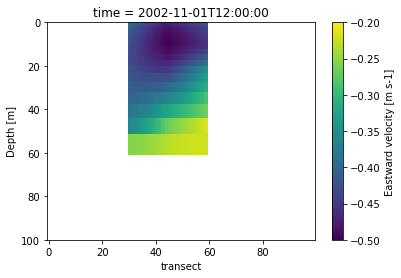

In [9]:
fig, ax = plt.subplots(1,1)
u1.isel(time=0).plot(ax=ax,vmin=-.5,vmax=-.2)
ax.set_ylim([100,0])

In [10]:
lon_array = xr.DataArray(lons, dims='transect')
lat_array = xr.DataArray(lats, dims='transect')

In [11]:
u2 = transport.interpolate_transect(dsel.uo, lons, lats, fill_value=0)

(100.0, 0.0)

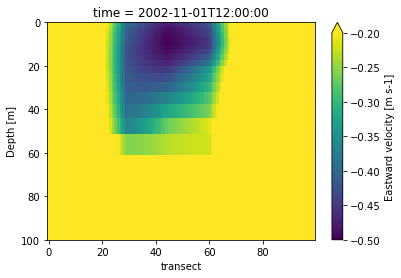

In [12]:
fig, ax = plt.subplots(1,1)
u2.isel(time=0).plot(ax=ax,vmin=-.5,vmax=-.2)
ax.set_ylim([100,0])

In [13]:
e3t_transect =transport.interpolate_transect(coords.e3t, lons, lats, method='nearest')

(100.0, 0.0)

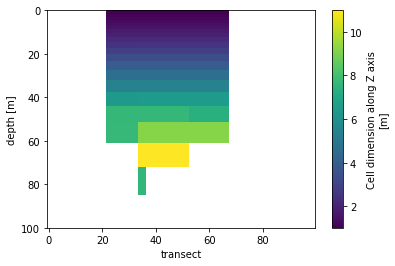

In [14]:
fig, ax = plt.subplots(1,1)
e3t_transect.plot(ax=ax)
ax.set_ylim([100,0])

In [15]:
mask_transect =transport.interpolate_transect(mask.mask, lons, lats, method='nearest')

(100.0, 0.0)

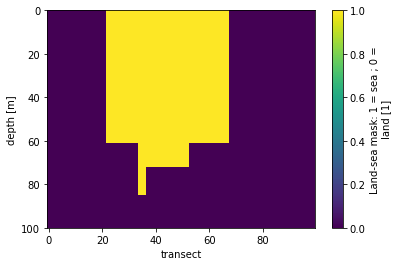

In [16]:
fig, ax = plt.subplots(1,1)
mask_transect.plot(ax=ax)
ax.set_ylim([100,0])

In [17]:
H2 = (mask_transect*e3t_transect).sum(dim='depth', skipna=True)

In [18]:
H2

<xarray.DataArray (transect: 100)>
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 59.01856422, 59.01856422, 59.01856422,
       59.01856422, 59.01856422, 59.01856422, 59.01856422, 59.01856422,
       59.01856422, 59.01856422, 59.01856422, 59.01856422, 79.06800246,
       79.06800246, 79.06800246, 71.45988643, 71.45988643, 71.45988643,
       71.45988643, 71.45988643, 71.45988643, 71.45988643, 71.45988643,
       71.45988643, 71.45988643, 71.45988643, 71.45988643, 71.45988643,
       71.45988643, 71.45988643, 71.45988643, 60.16770959, 60.16770959,
       60.16770959, 60.16770959, 60.16770959, 60.16770959, 60.16770959,
       60.16770959, 60.16770959, 60.16770959, 60.16770959, 60.16770959,
       60.16770959, 60.16770959, 60.16770959,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])
Coordinates:
    longitude  (transect) float64 -56.25 -56.25 -56.25 ... -56.12 -56.12 -56.12
    latitude   (transect) float64 51.91 51.9 51.9 51.89 ... 51.38 51.38 51.37
Dimensions without coordinates: transect

In [19]:
depth = transport.interpolate_transect(mask.deptho, lons, lats)

In [20]:
depth=depth.where(~np.isnan(depth), 0)

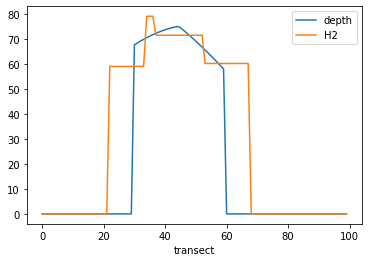

In [21]:
fig, ax = plt.subplots(1,1)
depth.plot(ax=ax, label= 'depth')
H2.plot(ax=ax, label='H2')
ax.legend()

In [22]:
V1=0
V2=0
for i in range(len(transect_vector)):
    length=np.abs(transect_vector[i])
    V1 += depth.isel(transect=i)*length
    V2 += H2.isel(transect=i)*length

In [23]:
print(V1, V2)

<xarray.DataArray 'deptho' ()>
array(766356.90855012)
Coordinates:
    longitude  float64 -56.25
    latitude   float64 51.91 <xarray.DataArray ()>
array(1103945.90029815)
Coordinates:
    longitude  float64 -56.25
    latitude   float64 51.91


(51.0, 52.0)

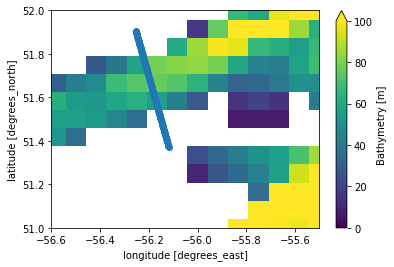

In [24]:
fig,ax = plt.subplots(1,1)
mask.deptho.plot(ax=ax,vmin=0,vmax=100)
ax.plot(lons,lats,'o')
ax.set_xlim([-56.6,-55.5])
ax.set_ylim([51,52])

(51.0, 52.0)

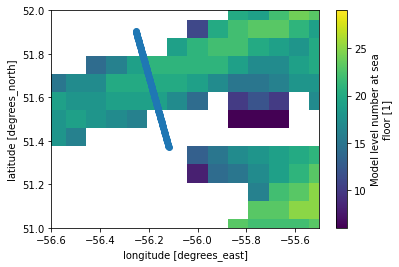

In [25]:
fig,ax = plt.subplots(1,1)
mask.deptho_lev.plot(ax=ax)
ax.plot(lons,lats,'o')
ax.set_xlim([-56.6,-55.5])
ax.set_ylim([51,52])

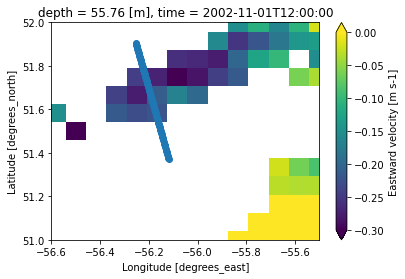

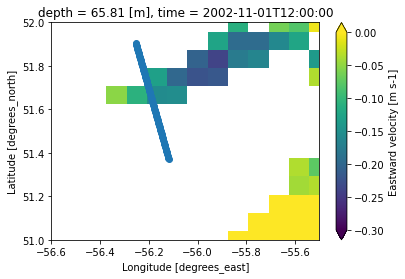

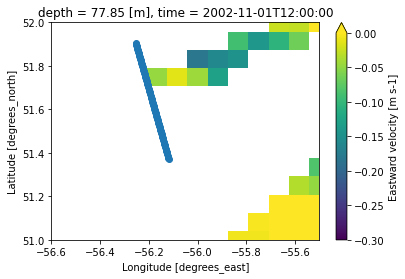

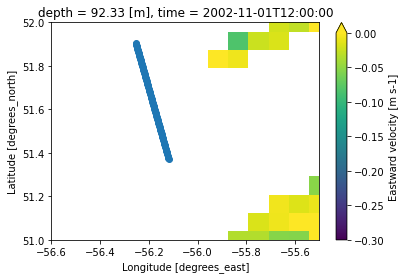

In [26]:
for level in [18,19,20,21]:
    fig,ax = plt.subplots(1,1)
    dsel.uo.isel(depth=level, time=0).plot(ax=ax,vmin=-.3,vmax=0)
    ax.plot(lons,lats,'o')
    ax.set_xlim([-56.6,-55.5])
    ax.set_ylim([51,52])